In [2]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
import pickle

from ttt_env import TicTacToeEnvironment
from ttt_agent import TicTacToeAgent

In [77]:
def train_agent(n_episodes):
    agent = TicTacToeAgent()
    env = TicTacToeEnvironment()

    total_reward = [0,]

    for episode in tqdm(range(n_episodes)):

        state = env.reset()
        done = False
        turn = 'X'

        history = []

        # Сама игра
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action, turn)
            history.append([state, action])
            state = next_state

            if done:
                break
            turn = 'X' if turn == 'O' else 'O'

        total_reward.append(total_reward[-1] + reward)

        # Тут происходит обновление Q значений на всех этапах партии
        game_duration = len(history)
        agent.update_q_table(*history[game_duration - 1], reward, state)
        agent.update_q_table(*history[game_duration - 2], -1e9 if reward == 1 else reward, history[game_duration - 1][0])

        sign = 1
        lr = 0.5
        for i in range(game_duration - 3, -1, -1):
            agent.update_q_table(*history[i], sign * reward, history[i + 1][0])
            if reward == 1:
               sign *= -1
            lr *= lr

        agent.decrease_exploration()
    return agent, total_reward

Функция `play_all_games` предназначена для перебора всех возможных партий, где агент играет за одного из игроков (например, за 'O'). Основная цель функции — сгенерировать все возможные исходы игры, используя все возможные ответы на каждый ход агента. Таким образом, получается некое "дерево" исходов и можно оценить долю всех последовательностей действий ведущих к одному из результатов.

In [63]:
def play_all_games(agent, env, state, agent_turn, turn='X'):
    results = []
    next_turn = 'O' if turn == 'X' else 'X'

    if agent_turn == turn:
        action = agent.choose_action(state)
        new_state, reward, done = env.step(action, turn)
        if done:
            return ['agent' if reward == 1 else 'draw', ]
        for i in play_all_games(agent, env, new_state, agent_turn, next_turn):
            results.append(i)
    else:
        for action in agent.get_possible_actions(state):
            new_env = deepcopy(env)
            new_state, reward, done = new_env.step(action, turn)

            if done:
                results.append('user' if reward == 1 else 'draw', )
            else:
                for i in play_all_games(agent, new_env, new_state, agent_turn, next_turn):
                    results.append(i)
    return results

Эта функция делает n симуляций и усредняет результаты, таким образом мы получаем устойчивую "метрику" качества работы агента.

In [66]:
def analyze(agent, n_simulations, agent_turn):
    user_cnt = 0
    agent_cnt = 0
    draw_cnt = 0
    for i in range(n_simulations):
        env = TicTacToeEnvironment()
        initial_state = env.reset()

        res = play_all_games(agent, env, initial_state, agent_turn)
        user_cnt += res.count('user')
        agent_cnt += res.count('agent')
        draw_cnt += res.count('draw')
    total = user_cnt + agent_cnt + draw_cnt
    print(f"wins when agent is {agent_turn}")
    lw, pw, cw = 8, 3, 6 # Для форматированния строк
    print(f"{'  user:':<{lw}} {user_cnt:>{cw}} {user_cnt / total * 100:>{pw}.0f}%")
    print(f"{'  agent:':<{lw}} {agent_cnt:>{cw}} {agent_cnt / total * 100:>{pw}.0f}%")
    print(f"{'  draw:':<{lw}} {draw_cnt:>{cw}} {draw_cnt / total * 100:>{pw}.0f}%")

In [144]:
# Результаты для необученного агента
analyze(TicTacToeAgent(), 100, 'X')
analyze(TicTacToeAgent(), 100, 'O')

wins when agent is X
  user:    9247  33%
  agent:  14000  50%
  draw:    4866  17%
wins when agent is O
  user:   48731  59%
  agent:  21727  26%
  draw:   12476  15%


In [84]:
n_episodes = int(3e5)

agent1, total_reward = train_agent(n_episodes)

100%|██████████| 300000/300000 [01:07<00:00, 4461.20it/s]


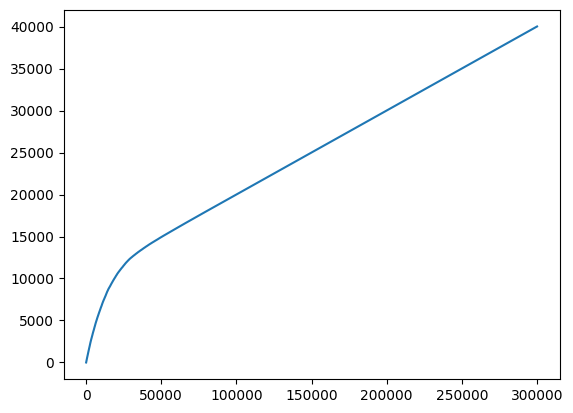

wins when agent is X
  user:       0   0%
  agent:  18900  89%
  draw:    2300  11%
wins when agent is O
  user:    9562  14%
  agent:  43653  65%
  draw:   13963  21%


In [85]:
plt.plot(total_reward)
plt.show()
analyze(agent1, 100, 'X')
analyze(agent1, 100, 'O')

Как видно из графика и метрик, агент с определенного момента перестал глобально учиться и стал играть примерно по одной стратегии, таким образом он отлично играет из определнных позиций, но в других он плохо ориентируется. Объединим несколько агентов, каждого со своими "проблемами"

In [ ]:
def merge(agents):
    super_agent = TicTacToeAgent()
    super_agent.epsilon = 0

    for agent in agents:
        for key in agent.q_table:
            if key in super_agent.q_table:
                super_agent.q_table[key] += agent.q_table[key]
            else:
                super_agent.q_table[key] = agent.q_table[key]
    return super_agent

In [87]:
n_agents = 7
agents = [agent1, ]
for i in range(n_agents):
    agents.append(train_agent(n_episodes)[0])

super_agent = merge(agents)
analyze(super_agent, 100, 'X')
analyze(super_agent, 100, 'O')

100%|██████████| 300000/300000 [01:05<00:00, 4551.28it/s]


wins when agent is X
  user:       0   0%
  agent:  23500  98%
  draw:     400   2%
wins when agent is O
  user:       0   0%
  agent:  59400  86%
  draw:    9700  14%


Агент перестал проигрывать. Попробуем еще улучшить его

In [88]:
n_agents = 8
agents = [super_agent, ]
for i in range(n_agents):
    agents.append(train_agent(n_episodes)[0])

super_agent = merge(agents)
analyze(super_agent, 100, 'X')
analyze(super_agent, 100, 'O')

100%|██████████| 300000/300000 [01:06<00:00, 4532.30it/s]


wins when agent is X
  user:       0   0%
  agent:  24700  98%
  draw:     400   2%
wins when agent is O
  user:       0   0%
  agent:  62800  89%
  draw:    7900  11%


Агент стал сильнее, попробуем еще

In [89]:
n_agents = 8
agents = [super_agent, ]
for i in range(n_agents):
    agents.append(train_agent(n_episodes)[0])

super_agent = merge(agents)
analyze(super_agent, 100, 'X')
analyze(super_agent, 100, 'O')

100%|██████████| 300000/300000 [01:05<00:00, 4557.65it/s]


wins when agent is X
  user:       0   0%
  agent:  24900  98%
  draw:     400   2%
wins when agent is O
  user:       0   0%
  agent:  63200  89%
  draw:    7900  11%


Все, достигли оптимума

In [143]:
# Так же можно обучить большее количество менее обученных ботов, и мы получим те же результаты
n_agents = 20
agents = []
for i in range(n_agents):
    agents.append(train_agent(n_episodes // 10)[0])

new_agent = merge(agents)
analyze(new_agent, 100, 'X')
analyze(new_agent, 100, 'O')

100%|██████████| 30000/30000 [00:05<00:00, 5300.17it/s]


wins when agent is X
  user:       0   0%
  agent:  24500  98%
  draw:     400   2%
wins when agent is O
  user:       0   0%
  agent:  63200  89%
  draw:    7900  11%


Можно сделать вывод, что наш агент играет оптимально

In [145]:
with open('agent.pickle', 'wb') as f:
    pickle.dump(super_agent, f)

In [91]:
def print_board(board):
    translate = {1:'X', 0:'.', -1:'O'}
    for i in range(3):
        for j in range(3):
            print(translate[board[i * 3 + j]], end='')
        print()
    print()

# Симулирует партию игры агента с самим собой
def demo(agent):
    env = TicTacToeEnvironment()
    state = env.reset()
    turn = 'X'
    done = False
    while not done:
        action = agent.choose_action(state)

        next_state, reward, done = env.step(action, turn)
        state = next_state

        turn = 'X' if turn == 'O' else 'O'
        print_board(state)
        if done:
             break

In [146]:
demo(super_agent) # Видно, что ходы вполне осмысленные

...
.X.
...

O..
.X.
...

O..
.X.
X..

O.O
.X.
X..

OXO
.X.
X..

OXO
.X.
XO.

OXO
XX.
XO.

OXO
XXO
XO.

OXO
XXO
XOX

